Import libraries

In [4]:
# !pip install numpy requests nlpaug
# !pip install tensformers
# !pip install evaluate
# !pip install tensorboard
# !pip install accelerate -U
# !pip uninstall pillow
# !pip install pillow==9.4.0
import pandas as pd
import numpy as np

import torch

from sklearn.model_selection import train_test_split

from transformers import  TrainingArguments, Trainer
from transformers import BertTokenizer,BertForSequenceClassification

from transformers import BertForSequenceClassification

import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

import gc

/home/user/albaredh0/miniconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:

torch.cuda.empty_cache()
gc.collect()

3717

#### Data

In [40]:
MAX_SENTENCE_LENGTH=150
data_url='../train-balanced-sarcasm.csv'
#The model started overfitting in the mid of the second epoch so we make an early stopping
epochs=1

In [11]:
# read the dataset
df=pd.read_csv(data_url)

In [15]:
def get_comment_lengths(df, max_sentence_length):
    """
    Filter comments based on their lengths and extract corresponding labels.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the 'comment' and 'label' columns.
        max_sentence_length (int): The maximum allowed length for a comment.

    Returns:
        tuple: A tuple containing two lists - labels and comments.

    This function takes a DataFrame (`df`) containing 'comment' and 'label' columns and filters the comments
    based on their lengths, keeping only those with lengths less than the specified 'max_sentence_length'.
    The function also extracts the corresponding labels for the filtered comments.
    The resulting 'labels' and 'comments' are returned as a tuple.

    """

    # Calculate the length of each comment and store it in a new 'lengths' column in the DataFrame.
    df["lengths"] = df["comment"].astype(str).apply(len)

    # Filter the DataFrame to keep only the rows where the comment length is less than 'max_sentence_length'.
    filtered_rows = df[df["lengths"] < max_sentence_length]

    # Extract the labels for the filtered comments and convert them to a list.
    labels = filtered_rows["label"].tolist()

    # Extract the filtered comments and convert them to a list of strings.
    comments = filtered_rows["comment"].astype(str).tolist()

    # Return the labels and comments as a tuple.
    return labels, comments

# Usage of the function
labels, comments = get_comment_lengths(df, MAX_SENTENCE_LENGTH)


#### Model

In [13]:

# Set the name of the pre-trained BERT model to be used.
model_name = "bert-base-uncased"

# Create a tokenizer for the selected BERT model.
# The tokenizer is responsible for converting text inputs into tokenized encodings that the model can process.
tokenizer = BertTokenizer.from_pretrained(model_name)

# Create an instance of the pre-trained BERT model for sequence classification.
# The `BertForSequenceClassification` class is designed for text classification tasks,
# where the input is a sequence of tokens, and the output is a class prediction.
# In this case, we are using a binary classification model (num_labels=2) which predicts one of two classes.
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [14]:
# ----- 1. Preprocess data -----#
# Preprocess data
# Convert the 'comments' and 'labels' lists to separate variables 'X' and 'y'.
X = list(comments)
y = list(labels)

# Split the data into training and validation sets using train_test_split.
# The test_size parameter specifies the proportion of the data to be used for validation (in this case, 30%).
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

# Tokenize the training data (X_train) and validation data (X_val) using the 'tokenizer'.
# The tokenizer converts the text inputs into tokenized encodings with padding and truncation.
# The maximum sequence length is set to 512, which is the maximum allowed by the BERT model.
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)


In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    """
    Custom PyTorch Dataset class for working with tokenized encodings and labels.

    Parameters:
        encodings (dict): A dictionary containing the tokenized encodings of the dataset.
                          The dictionary should have keys like 'input_ids', 'attention_mask', etc.,
                          and each key should have a list of torch tensors as its values.
        labels (list or None): Optional. A list containing the labels corresponding to each sample in the dataset.
                               If provided, the dataset will return labels along with the tokenized encodings.

    This class allows you to work with tokenized encodings and labels as a PyTorch Dataset.
    It takes the tokenized encodings as input and optionally the corresponding labels.
    The tokenized encodings are usually obtained from a tokenizer provided by the Hugging Face transformers library.

    Methods:
        __getitem__(self, idx): Returns a bacth from the dataset at the given index.
                                The sample is returned as a dictionary containing the tokenized encodings and labels (if available).
        __len__(self): Returns the total number of samples in the dataset.


    """
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])




In [ ]:
# Create the training dataset using the 'Dataset' class with the tokenized training data (X_train_tokenized) and labels (y_train).
train_dataset = Dataset(X_train_tokenized, y_train)

# Create the validation dataset using the 'Dataset' class with the tokenized validation data (X_val_tokenized) and labels (y_val).
val_dataset = Dataset(X_val_tokenized, y_val)


#### Training

In [ ]:
# define evaluation metrics
def compute_metrics(p):
    """
    Compute evaluation metrics for a binary-class classification problem.

    Parameters:
        p (tuple): A tuple containing the predictions and the true labels.
                   The predictions should be in the form of a 2D numpy array with shape (num_samples, num_classes),
                   where each row represents the predicted probabilities for each class.
                   The true labels should be a 1D numpy array of shape (num_samples,) or a list containing the ground truth labels.

    Returns:
        dict: A dictionary containing the computed evaluation metrics.
              The dictionary has the following keys: 'accuracy', 'precision', 'recall', 'f1'.

    This function calculates the accuracy, precision, recall, and F1-score for a binary-class classification problem.
    It takes in the predicted probabilities and the true labels as inputs.
    The predicted probabilities are converted to class labels using argmax to get the most probable class for each sample.


    """
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Train model function
def train_model(model,train_dataset,val_dataset, epochs=epochs):
      """
    Function to train a pre-trained model on the provided training dataset.

    Parameters:
        model (transformers.PreTrainedModel): The pre-trained model to be trained.
        train_dataset (torch.utils.data.Dataset): The training dataset.
        val_dataset (torch.utils.data.Dataset): The validation dataset.
        epochs (int, optional): The number of training epochs. Default is 3.

    Returns:
        None
        """
    args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=256,
    num_train_epochs=epochs,
    seed=0,
    load_best_model_at_end=True,
)
    trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train pre-trained model
    trainer.train()
    

In [ ]:
train_model(train_dataset=train_dataset,model=model,val_dataset=val_dataset)

### Plot

In [16]:


def plot_loss(trainer_state_path, window_size=3):
    """
    Plot training and validation loss from the trainer state.

    Parameters:
        trainer_state_path (str): Path to the JSON file containing the trainer state.
        window_size (int, optional): Size of the moving average window for smoothing the loss curves. Default is 3.

    Returns:
        None

    This function loads the trainer state from the specified JSON file, extracts the training and validation loss
    from the log history, and plots the smoothed loss curves using the specified window_size for moving average smoothing.

    """

    # Load the trainer state from the JSON file
    with open(trainer_state_path) as f:
        data = json.load(f)

    # Extract training and validation loss from the log history
    history = data["log_history"]
    train_loss = [entry["loss"] for i, entry in enumerate(history) if i % 2 == 0]
    val_loss = [entry["eval_loss"] for i, entry in enumerate(history) if i % 2 != 0]

    # Smooth the loss curves using moving average
    train_loss_smooth = np.convolve(train_loss, np.ones(window_size) / window_size, mode='valid')
    val_loss_smooth = np.convolve(val_loss, np.ones(window_size) / window_size, mode='valid')

    # Create the steps range for plotting
    steps = range(window_size, window_size + len(train_loss_smooth))

    # Plot the smoothed loss curves
    plt.plot(steps, train_loss_smooth, 'b', label='Training Loss')
    plt.plot(steps, val_loss_smooth, 'r', label='Validation Loss')

    # Set plot title and labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')

    # Display the legend
    plt.legend()

    # Show the plot
    plt.show()


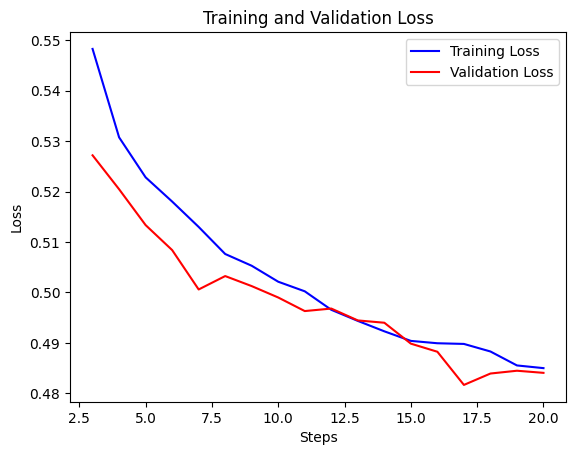

In [48]:
plot_loss(trainer_state_path='output/checkpoint-10000/trainer_state.json')

In [38]:
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy(trainer_state_path, window_size=3):
    """
    Plot evaluation accuracy and F1 score from the trainer state.

    Parameters:
        trainer_state_path (str): Path to the JSON file containing the trainer state.
        window_size (int, optional): Size of the moving average window for smoothing the accuracy and F1 score curves. Default is 3.

    Returns:
        None

    This function loads the trainer state from the specified JSON file, extracts the evaluation accuracy and F1 score
    from the log history, and plots the smoothed curves using the specified window_size for moving average smoothing.

    Note: Make sure to have the 'matplotlib' library installed to visualize the plot.
    """

    # Load the trainer state from the JSON file
    with open(trainer_state_path) as f:
        data = json.load(f)

    # Extract evaluation accuracy and F1 score from the log history
    history = data["log_history"]
    accuracy_score = [entry["eval_accuracy"] for i, entry in enumerate(history) if i % 2 != 0]
    eval_f1_score = [entry["eval_f1"] for i, entry in enumerate(history) if i % 2 != 0]


    # Smooth the accuracy and F1 score curves using moving average
    accuracy_score_smooth = np.convolve(accuracy_score, np.ones(window_size) / window_size, mode='valid')
    val_f1_score_smooth = np.convolve(eval_f1_score, np.ones(window_size) / window_size, mode='valid')


    # Create the steps range for plotting
    steps = range(window_size, window_size + len(accuracy_score_smooth))

    # Plot the smoothed accuracy and F1 score curves
    plt.plot(steps, accuracy_score_smooth, 'b', label='Smoothed eval accuracy')
    plt.plot(steps, val_f1_score_smooth, 'r', label='Smoothed eval F1 score')


    # Set plot title, labels, and legend
    plt.title('Bert Smoothed Accuracy and F1 score')
    plt.xlabel('Steps')
    plt.legend()

    # Show the plot
    plt.show()


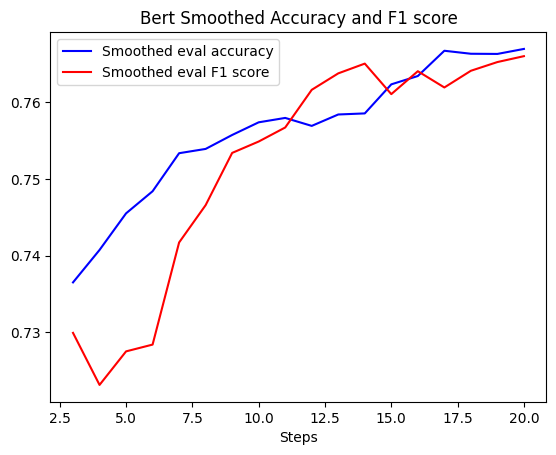

In [39]:
plot_accuracy(trainer_state_path="output/checkpoint-10000/trainer_state.json")